## Importing Packages

In [5]:
import numpy as np
import pandas as pd
import nltk
from sklearn import metrics
from nltk.tag import pos_tag
from sklearn import preprocessing
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet, stopwords
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Mounting Google Drive

In [6]:
import sys                                                                  
from google.colab import files
sys.path.insert(0,'/content/drive/MyDrive/Assignment3')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading CSV

In [8]:
labels=["docID", "Title", "Content", "Preprocessed" , "Lemmatized" , "Type"]
raw_data = ""

def getTrainingDataset():
    return pd.read_csv('/content/drive/MyDrive/Assignment3/clean_data.csv', header=None, names=labels)  

raw_data = getTrainingDataset()

raw_data.head()

,docID,Title,Content,Preprocessed,Lemmatized,Type
0,0,http:^^www.cs.wisc.edu^~cs564-1^cs564.html,\n\nCS 564 - Database Management Systems: Desi...,cs database management systems design implemen...,c database management system design implementa...,Course
1,1,http:^^www.cs.washington.edu^education^courses...,\nCSE 413 (Winter 1996) Home Page\n\nCSE 413 ...,cse winter home page cse winter programming la...,cse winter home page cse winter programming la...,Course
2,2,http:^^www.cs.wisc.edu^~ferris^cs719.html,"\n\n CS 719, Spring 1996 \n\n\n\n\n CS 719: N...",cs spring cs network flows spring schedule lec...,c spring c network flow spring schedule lectur...,Course
3,3,http:^^www.cs.washington.edu^education^courses...,\n\nCSE 451 Home Page\n\n\n\nCSE 451\nIntroduc...,cse home page cse introduction operating syste...,cse home page cse introduction operating syste...,Course
4,4,http:^^www.cs.wisc.edu^~turnidge^cs302.html,"\n\nCS302, Section 19\n\n\nComputer Science 30...",cs section computer science section time mwf p...,c section computer science section time mwf pl...,Course


# Creating Noun Dictionary

In [10]:
nounFrequency = defaultdict()

def createNounFrequency(sentence):
    token_words = word_tokenize(sentence)

    """Checking if the word is noun or not"""
    
    for word in token_words:
        ans = nltk.pos_tag(word)
        val = ans[0][1]
        if(val == 'NN' or val == 'NNS' or val == 'NNPS' or val == 'NNP'):
            if word in nounFrequency:
                count = nounFrequency[word]
                nounFrequency[word] = count + 1
            else:
                nounFrequency[word] = 1
   

In [11]:
raw_data["Lemmatized"].apply(lambda x: createNounFrequency(x))

0       None
1       None
2       None
3       None
4       None
        ... 
1046    None
1047    None
1048    None
1049    None
1050    None
Name: Lemmatized, Length: 1051, dtype: object

In [12]:
"""Noun Selection"""

#Sorting by their frequencies
nounFrequency = sorted(nounFrequency.items(), key=lambda item: item[1])
nounFrequency = list(nounFrequency)

#Choosing the top 50 nouns based on frequency
topFiftyNouns = nounFrequency[-50:]
print(topFiftyNouns)

[('file', 305), ('conference', 308), ('proceeding', 310), ('phone', 313), ('texas', 314), ('object', 333), ('list', 334), ('exam', 338), ('computing', 339), ('r', 341), ('j', 342), ('distributed', 355), ('hour', 358), ('postscript', 360), ('design', 363), ('homework', 365), ('wisconsin', 365), ('b', 367), ('p', 392), ('cse', 397), ('link', 413), ('group', 417), ('problem', 417), ('work', 458), ('last', 462), ('wisc', 468), ('interest', 473), ('web', 521), ('e', 523), ('parallel', 523), ('lecture', 537), ('software', 556), ('engineering', 564), ('student', 570), ('time', 576), ('class', 601), ('language', 648), ('cornell', 652), ('program', 762), ('course', 776), ('programming', 830), ('department', 868), ('information', 923), ('project', 939), ('research', 1094), ('home', 1246), ('edu', 1331), ('system', 1731), ('computer', 2293), ('c', 3413)]


# Creating Bi-grams

In [13]:
corpusBigrams = []

def createBigrams(sentence):
  token_words = word_tokenize(sentence)
  tempBigrams = list(nltk.bigrams(token_words))
  for i in tempBigrams:
    corpusBigrams.append(i)

In [14]:
for index , row in raw_data.iterrows():
    createBigrams(row['Lemmatized'])

In [15]:
print(corpusBigrams[2:10])

[('management', 'system'), ('system', 'design'), ('design', 'implementation'), ('implementation', 'c'), ('c', 'database'), ('database', 'management'), ('management', 'system'), ('system', 'design')]


In [16]:
FiftyNouns = []
for words in topFiftyNouns:
  FiftyNouns.append(words[0])

In [17]:
"""Forming Co-Occurance"""

#If the noun exists in bigram then shortlist it

co_occurance = []

for words in corpusBigrams:
  if words[0] in FiftyNouns or words[1] in FiftyNouns:
    if words[0] not in co_occurance:
      co_occurance.append(words[0])
    if words[1] not in co_occurance:
      co_occurance.append(words[1])

In [18]:
print(co_occurance)

['c', 'database', 'management', 'system', 'design', 'implementation', 'course', 'information', 'postscript', 'version', 'new', 'class', 'friday', 'office', 'hour', 'time', 'assignment', 'text', 'last', 'updated', 'handout', 'mailing', 'list', 'solution', 'exercise', 'first', 'day', 'overview', 'topic', 'minibase', 'home', 'page', 'html', 'year', 'sample', 'key', 'midterm', 'using', 'sybase', 'info', 'www', 'resource', 'tutorial', 'tree', 'language', 'construction', 'graded', 'experience', 'phone', 'e', 'mail', 'raghu', 'mw', 'pm', 'lecture', 'discussion', 'mwf', 'xbao', 'thur', 'modified', 'cse', 'winter', 'programming', 'tanimoto', 'department', 'computer', 'science', 'engineering', 'university', 'sln', 'schedule', 'tuesday', 'monday', 'sieg', 'archive', 'past', 'also', 'grading', 'homework', 'exam', 'final', 'project', 'participation', 'reading', 'online', 'throughout', 'including', 'logic', 'prolog', 'parsing', 'understanding', 'shell', 'expert', 'either', 'introduction', 'common', 

## Splitting Data Into Training And Testing

In [19]:
X = raw_data["Lemmatized"]
Y = raw_data["Type"]

vectorizer = TfidfVectorizer()  

vectorizer.fit(co_occurance)
X_tfidf = vectorizer.transform(X)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.3, random_state=42)

## Applying Multinomial Naive Bayes

In [26]:
model = MultinomialNB()
model.fit(X_train, Y_train)

MultinomialNB()

In [27]:
Y_Pred = model.predict(X_test)

## Visualization

Accuracy score with Multinomial Naive Bayes is : 
86.39240506329115
              precision    recall  f1-score   support

      Course       1.00      0.37      0.54        68
   No Course       0.85      1.00      0.92       248

    accuracy                           0.86       316
   macro avg       0.93      0.68      0.73       316
weighted avg       0.88      0.86      0.84       316



Text(0.5, 87.0, 'Predicted lable')

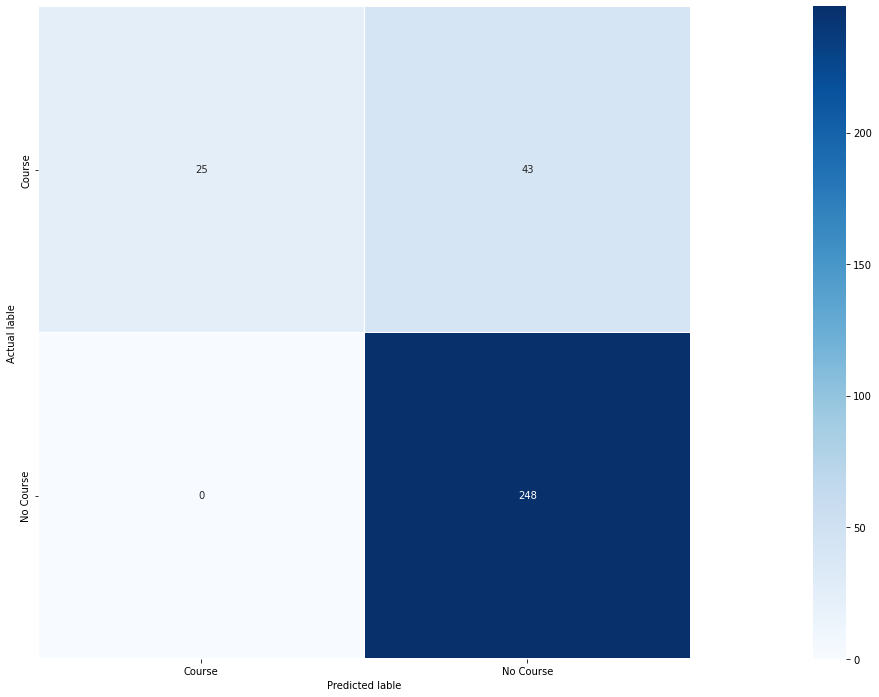

In [28]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

print('Accuracy score with Multinomial Naive Bayes is : ')
print(metrics.accuracy_score(Y_test,Y_Pred)*100)
cf_matrix = confusion_matrix(Y_test, Y_Pred)
print(classification_report(Y_test, Y_Pred))

plt.figure(figsize=(44,12))

unique_label = ["Course" , "No Course"]

sns.heatmap(cf_matrix,annot=True ,fmt='d',  cmap='Blues',square=True ,cbar=True, linewidths=.10, xticklabels= unique_label, yticklabels= unique_label  )
plt.ylabel('Actual lable')
plt.xlabel('Predicted lable')

## **Saving Models**

In [24]:
import pickle
pickle.dump(model, open('model_Topic.pickle', 'wb'))
pickle.dump(vectorizer, open("vectorizer_Topic.pickle", "wb"))